In [1]:
class Particle:
    def __init__(self, particleText):
        
        #Get our list of quantities for the particle
        particleInfo = particleText.split(",")
        
        #Define our particle quantities
        self.obj = particleInfo[0]
        self.E = float(particleInfo[1])
        self.pt = float(particleInfo[2])
        self.eta = float(particleInfo[3])
        self.phi = float(particleInfo[4])
        
    def __str__(self):
        return "(obj: " + self.obj + ", E: " + str(self.E) + ", pt: " + str(self.pt) + ", eta: " + str(self.eta) + ", phi: " +str(self.phi) + ")"
    
    def getQuantity(self, quantityType):
        
        if quantityType == "E":
            return self.E
        
        elif quantityType == "pt":
            return self.pt
        
        elif quantityType == "eta":
            return self.eta
        
        elif quantityType == "phi":
            return self.phi

        else:
            print("Error: Invalid quantity type")
            return 0.0
        
    __repr__=__str__

In [2]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from random import shuffle
from sklearn.metrics import roc_curve, auc, mean_squared_error

In [3]:
def checkJets(obj):
    return obj in ["j", "b"]

def checkLeptons(obj):
    return obj in ["e-", "e+", "m-", "m+"]

def checkPhotons(obj):
    return obj=="g"

In [4]:
def makeParticleList(eventInfo):
    
    #total number of datapoints in the line
    length = len(eventInfo)
    
    particleList = []
    
    #Increment over all of the particles in the line
    for i in range(5, length):
        
        #Get the text for the particle
        particleText = eventInfo[i]
        
        #Make sure that it is actually information for the particle
        if particleText != "" and particleText != "\n":
            
            particle = Particle(particleText)
            
            particleList.append(particle)
    
    return particleList

In [5]:
def makeEvent(line, signal):
    
    eventInfo = line.split(";")
    
    eventID = eventInfo[0]
    processID = eventInfo[1]
    eventWeight = float(eventInfo[2])
    MET = float(eventInfo[3])
    METPhi = float(eventInfo[4])
    
    signal = float(signal)
    
    particleList = makeParticleList(eventInfo)
    
    crossSection = 1.0
    
    event = {
        "eventID" : eventID,
        "processID" : processID,
        "eventWeight" : eventWeight,
        "MET" : MET,
        "METPhi" : METPhi,
        "particleList" : particleList,
        "crossSection" : crossSection,
        "signal" : signal
    }
    
    return event

In [6]:
def calculateSignalCrossSection(event, length):
    
    eventWeight = event["eventWeight"]
    
    crossSection = eventWeight*length
    
    return crossSection

In [7]:
def calculateBackgroundCrossSection(length, luminosity):
    
    crossSection = length/luminosity
    
    return crossSection

In [8]:
def calculateCrossSection(event, length, luminosity, signal):
    if signal:
        return calculateSignalCrossSection(event, length)
    else:
        return calculateBackgroundCrossSection(length, luminosity)

In [9]:
def makeDataList(filePath, signal, luminosity = 1.0):
    
    file = open(filePath, "r")
    
    dataList = []
    
    for line in file:
        
        event = makeEvent(line, signal)
        
        dataList.append(event)

    file.close()
    
    length = float(len(dataList))
    
    for event in dataList:
        
        event["crossSection"] = calculateCrossSection(event, length, luminosity, signal)
    
    
    return dataList

In [10]:
def makeParticleVectors(event):
    
    particleVectors = []
    particleList = event["particleList"]
    length = len(particleList)
    
    #jets = []
    #leptons = []
    
    #for particle in particleList:
        #if checkJets(particle.obj):
            #jets.append(particle)
        #elif checkLeptons(particle.obj):
            #leptons.append(particle)
    
    #jetNumber = len(jets)
    #leptonNumber = len(leptons)
    
    #for i in range(0, 6):
        #if i < jetNumber:
            #jet = jets[i]
            #particleVectors.append(jet.pt)
            #particleVectors.append(jet.eta)
            #particleVectors.append(jet.phi)
            #particleVectors.append(jet.E)
        #else:
            #for j in range(0, 4):
                #particleVectors.append(0.0)
    
    #for i in range(0, 2):
        #if i < leptonNumber:
            #lepton = leptons[i]
            #particleVectors.append(lepton.pt)
            #particleVectors.append(lepton.eta)
            #particleVectors.append(lepton.phi)
            #particleVectors.append(lepton.E)
        #else:
            #for j in range(0, 4):
                #particleVectors.append(0.0)
        
    for i in range(0, 8):
        if i < length:
            particle = particleList[i]
            particleVectors.append(particle.pt)
            particleVectors.append(particle.eta)
            particleVectors.append(particle.phi)
            particleVectors.append(particle.E)
        else:
            for n in range(0, 4):
                particleVectors.append(0.0)
    
    return particleVectors

In [11]:
def scaleData(data):
    
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(data)
    return scaledData

In [12]:
def formatAutoencoderData(dataList):
    
    autoencoderData = []
    
    for event in dataList:
        particleVectors = makeParticleVectors(event)
        
        #tensor = tf.constant([particleVectors[0], particleVectors[1], particleVectors[2], particleVectors[3], particleVectors[4], particleVectors[5], particleVectors[6], particleVectors[7], event["MET"], event["METPhi"]])
        
        autoencoderData.append([particleVectors[0], particleVectors[1], particleVectors[2], particleVectors[3], particleVectors[4], particleVectors[5], particleVectors[6], particleVectors[7], particleVectors[8], particleVectors[9], particleVectors[10], particleVectors[11], particleVectors[12], particleVectors[13], particleVectors[14], particleVectors[15], particleVectors[16], particleVectors[17], particleVectors[18], particleVectors[19], particleVectors[20], particleVectors[21], particleVectors[22], particleVectors[23], particleVectors[24], particleVectors[25], particleVectors[26], particleVectors[27], particleVectors[28], particleVectors[29], particleVectors[30], particleVectors[31], event["MET"], event["METPhi"], event["signal"]])
    
    scaledData = scaleData(autoencoderData)
    print(scaledData)
    
    autoencoderDataframe = pd.DataFrame(data = scaledData, columns = ["Particle1PT", "Particle1Eta", "Particle1Phi", "Particle1E", "Particle2PT", "Particle2Eta", "Particle2Phi", "Particle2E", "Particle3PT", "Particle3Eta", "Particle3Phi", "Particle3E", "Particle4PT", "Particle4Eta", "Particle4Phi", "Particle4E", "Particle5PT", "Particle5Eta", "Particle5Phi", "Particle5E", "Particle6PT", "Particle6Eta", "Particle6Phi", "Particle6E", "Particle7PT", "Particle7Eta", "Particle7Phi", "Particle7E", "Particle8PT", "Particle8Eta", "Particle8Phi", "Particle8E", "MET", "METPhi", "Signal"])
    
    return autoencoderDataframe
        
        

In [13]:
def calculateAutoencoderError(X_Test, autoencoder):
    
    distortedData = autoencoder.predict(X_Test)
    
    X_Test = X_Test.to_numpy()
    y_predict = []
    
    for i in range(0, len(distortedData)):
        testEvent = X_Test[i]
        distortedEvent = distortedData[i]
        predict = 0.0
        for j in range(0, len(distortedEvent)):
            predict += (distortedEvent[j]-testEvent[j])**2
        y_predict.append(predict)
    
    #y_predict = scaleData(np.reshape(y_predict, (-1, 1)))
    
    return y_predict

In [14]:
def normalizeArea(hist, bin_edges):
    
    bin_size = bin_edges[1] - bin_edges[0]
    integral = sum(hist) * bin_size
    normalizedCount = (1.0/integral) * hist
    
    return normalizedCount

In [15]:
def plotHistogram(y_Predict, x_Predict, numBins):
    y_hist, bin_edges = np.histogram(y_Predict, bins=numBins)
    normalizedYCount = normalizeArea(y_hist, bin_edges)
    plt.step(bin_edges[1:], normalizedYCount, label="Signal")
    x_hist, bin_edges = np.histogram(x_Predict, bins=numBins)
    normalizedXCount = normalizeArea(x_hist, bin_edges)
    plt.step(bin_edges[1:], normalizedXCount, label="Background")
    plt.legend()
    plt.show()
    plt.close()

In [16]:
backgroundDataList = makeDataList("Data/training_files/training_files/chan1/background_chan1_7.79.csv", False, luminosity = 7.79)
signalDataList = makeDataList("Data/training_files/training_files/chan1/glgl1400_neutralino1100_chan1.csv", True)
length = len(signalDataList)
testDataList = signalDataList+backgroundDataList[:length]
trainingDataList = backgroundDataList[length:]

In [17]:
autoencoderBackgroundData = formatAutoencoderData(trainingDataList)
autoencoderTestData = formatAutoencoderData(testDataList)

[[0.03119086 0.97093983 0.23618605 ... 0.05855334 0.57428654 0.        ]
 [0.11816892 0.83004629 0.82715489 ... 0.05185371 0.29118767 0.        ]
 [0.0178816  0.18724195 0.70490233 ... 0.04401252 0.14580472 0.        ]
 ...
 [0.05108204 0.16346058 0.68674421 ... 0.0793834  0.2687705  0.        ]
 [0.05124701 0.34005743 0.12829095 ... 0.01522025 0.57889157 0.        ]
 [0.19189365 0.39894424 0.66459127 ... 0.05038262 0.15621832 0.        ]]
[[0.44230631 0.53252889 0.28663354 ... 0.39031068 0.80018814 1.        ]
 [0.02211443 0.43175951 0.04826736 ... 0.0368723  0.45957905 1.        ]
 [0.05541422 0.70105408 0.27135368 ... 0.06456814 0.5787892  1.        ]
 ...
 [0.05114402 0.59820906 0.34872379 ... 0.00397095 0.89039166 0.        ]
 [0.0381824  0.51921991 0.67220093 ... 0.13426695 0.21114341 0.        ]
 [0.19733478 0.56433782 0.47852827 ... 0.04035451 0.98546111 0.        ]]


In [18]:
VarNames = ["Particle1PT", "Particle1Eta", "Particle1Phi", "Particle1E", "Particle2PT", "Particle2Eta", "Particle2Phi", "Particle2E", "Particle3PT", "Particle3Eta", "Particle3Phi", "Particle3E", "Particle4PT", "Particle4Eta", "Particle4Phi", "Particle4E", "Particle5PT", "Particle5Eta", "Particle5Phi", "Particle5E", "Particle6PT", "Particle6Eta", "Particle6Phi", "Particle6E", "Particle7PT", "Particle7Eta", "Particle7Phi", "Particle7E", "Particle8PT", "Particle8Eta", "Particle8Phi", "Particle8E", "MET", "METPhi"]
autoencoderBackgroundData = autoencoderBackgroundData[VarNames]
X_Test = autoencoderTestData[VarNames]
y_Test = autoencoderTestData["Signal"]

In [19]:
input_dim=autoencoderBackgroundData.shape[1]

input_vec = Input(shape =(input_dim,))

encoded = Dense(34, activation='relu')(input_vec)
encoded = Dense(200, activation='tanh')(encoded)
encoded = Dense(200, activation='tanh')(encoded)
encoded = Dense(20, activation='tanh')(encoded)
#encoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(20, activation='tanh')(decoded)
decoded = Dense(200, activation='tanh')(decoded)
decoded = Dense(200, activation='tanh')(decoded)
decoded = Dense(input_dim, activation='relu')(decoded)

autoencoder=Model(input_vec, decoded)


autoencoder.compile(optimizer="adam",
                    loss="mean_squared_error") 

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=20)

history=autoencoder.fit(autoencoderBackgroundData, autoencoderBackgroundData, epochs=100,
               batch_size=125,
               shuffle='batch',
               validation_split=0.1)

Epoch 1/100
1513/1513 [==============================] - 7s 4ms/step - loss: 0.0480 - val_loss: 0.0409
Epoch 2/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0409 - val_loss: 0.0409
Epoch 3/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 4/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 5/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 6/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 7/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 8/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 9/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0408 - val_loss: 0.0409
Epoch 10/100
1513/1513 [==============================] - 6s 4ms/step - l

Epoch 80/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 81/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 82/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 83/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 84/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 85/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 86/100
1513/1513 [==============================] - 7s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 87/100
1513/1513 [==============================] - 7s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 88/100
1513/1513 [==============================] - 6s 4ms/step - loss: 0.0259 - val_loss: 0.0260
Epoch 89/100
1513/1513 [==============================] - 7s 4ms

256/256 [==============================] - 1s 2ms/step


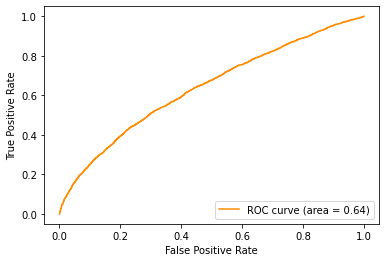

In [21]:
y_Predict = calculateAutoencoderError(X_Test, autoencoder)

fpr, tpr, _ = roc_curve(y_Test, y_Predict)
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


[[0.08998823 0.45238778 0.07265953 ... 0.10453648 0.58563025 0.        ]
 [0.08896573 0.71354308 0.1042361  ... 0.00959889 0.6056066  0.        ]
 [0.0878463  0.6195512  0.84369917 ... 0.01113379 0.26780442 0.        ]
 ...
 [0.05108204 0.16346058 0.68674421 ... 0.0793834  0.2687705  0.        ]
 [0.05124701 0.34005743 0.12829095 ... 0.01522025 0.57889157 0.        ]
 [0.19189365 0.39894424 0.66459127 ... 0.05038262 0.15621832 0.        ]]
[[0.44228382 0.53252889 0.28652306 ... 0.39029951 0.80005384 0.        ]
 [0.02207498 0.43175951 0.04800766 ... 0.03685465 0.4592158  0.        ]
 [0.05537611 0.70105408 0.27123364 ... 0.06455099 0.57850608 0.        ]
 ...
 [0.20838687 0.44164893 0.73604629 ... 0.29818148 0.15515017 0.        ]
 [0.08457757 0.63283131 0.23287148 ... 0.00271862 0.72562533 0.        ]
 [0.13981496 0.44208565 0.6215962  ... 0.16284956 0.07908586 0.        ]]
128/128 [==============================] - 0s 2ms/step


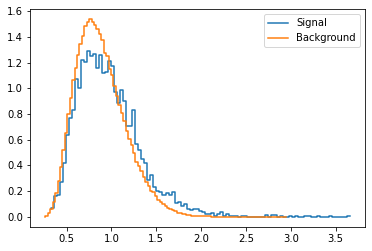

In [22]:
backgroundAutoencoderData = formatAutoencoderData(backgroundDataList)[VarNames]
signalAutoencoderData = formatAutoencoderData(signalDataList)[VarNames]
x_Predict = calculateAutoencoderError(backgroundAutoencoderData, autoencoder)
y_Predict = calculateAutoencoderError(signalAutoencoderData, autoencoder)

plotHistogram(y_Predict, x_Predict, 100)

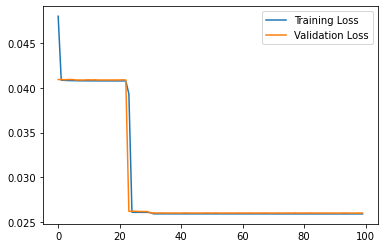

In [23]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

256/256 [==============================] - 0s 2ms/step


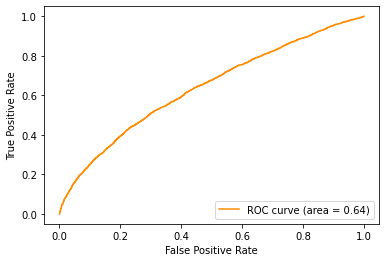

In [24]:
distortedData = autoencoder.predict(X_Test)
y_Predict = []
X_Test_numpy = X_Test.to_numpy()
for i in range(0, len(distortedData)):
    X = X_Test_numpy[i]
    Y = distortedData[i]
    predict = mean_squared_error(X, Y)
    y_Predict.append(predict)
    

fpr, tpr, _ = roc_curve(y_Test, y_Predict)
                        
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [25]:
backgroundAutoencoderData = formatAutoencoderData(backgroundDataList)
signalAutoencoderData = formatAutoencoderData(signalDataList)

#x_Predict = []
#autoencoderBackgroundData_numpy = autoencoderBackgroundData.to_numpy()
#for i in range(0, len(distortedDataTest)):
 #   X = autoencoderBackgroundData_numpy[i]
 #   Y = distortedDataTest[i]
 #   predict = mean_squared_error(X, Y)
 #   x_Predict.append(predict)

#plotHistogram(y_Predict, x_Predict, 100)

[[0.08998823 0.45238778 0.07265953 ... 0.10453648 0.58563025 0.        ]
 [0.08896573 0.71354308 0.1042361  ... 0.00959889 0.6056066  0.        ]
 [0.0878463  0.6195512  0.84369917 ... 0.01113379 0.26780442 0.        ]
 ...
 [0.05108204 0.16346058 0.68674421 ... 0.0793834  0.2687705  0.        ]
 [0.05124701 0.34005743 0.12829095 ... 0.01522025 0.57889157 0.        ]
 [0.19189365 0.39894424 0.66459127 ... 0.05038262 0.15621832 0.        ]]
[[0.44228382 0.53252889 0.28652306 ... 0.39029951 0.80005384 0.        ]
 [0.02207498 0.43175951 0.04800766 ... 0.03685465 0.4592158  0.        ]
 [0.05537611 0.70105408 0.27123364 ... 0.06455099 0.57850608 0.        ]
 ...
 [0.20838687 0.44164893 0.73604629 ... 0.29818148 0.15515017 0.        ]
 [0.08457757 0.63283131 0.23287148 ... 0.00271862 0.72562533 0.        ]
 [0.13981496 0.44208565 0.6215962  ... 0.16284956 0.07908586 0.        ]]
